In [1]:
import numpy as np
import pandas as pd
import math as m
import datetime as dt
import torch
import os

from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
data = pd.read_csv('Earthquake Data NW Himalaya.csv', sep=',')

In [3]:
data[0::70000]

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
0,2020-11-08T13:26:25.194Z,33.5089,75.7595,10.0,4.4,mb,NaN,147.0,2.084,0.59,...,2020-11-08T15:53:58.040Z,"21 km N of Kishtwār, India",earthquake,5.3,1.9,0.115,22.0,reviewed,us,us


In [4]:
import pandas as pd

def extract_time_components(time_string):
    try:
        dt = pd.to_datetime(time_string)
        return {
            'year': dt.year,
            'month': dt.month,
            'date': dt.day,
            'hour': dt.hour,
            'minute': dt.minute,
            'second': dt.second
        }
    except ValueError:
        return {'year': None, 'month': None, 'date': None, 'hour': None, 'minute': None, 'second': None}

data['time'] = pd.to_datetime(data['time'])
data = data.sort_values('time')

data.reset_index(drop=True, inplace=True)

result = data['time'].apply(extract_time_components).apply(pd.Series)

data[['year', 'month', 'date', 'hour', 'minute', 'second']] = result



In [5]:
data = data.replace([float('inf'), float('-inf')], float('nan')).fillna(0)

In [6]:
data.head()

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,magNst,status,locationSource,magSource,year,month,date,hour,minute,second
0,1905-04-04 00:49:59+00:00,32.636,76.788,20.0,7.9,mw,0.0,0.0,0.0,0.0,...,0.0,automatic,iscgem,iscgem,1905,4,4,0,49,59
1,1911-10-14 23:23:59+00:00,30.759,80.279,20.0,6.5,mw,0.0,0.0,0.0,0.0,...,0.0,automatic,iscgem,iscgem,1911,10,14,23,23,59
2,1914-10-09 02:39:14+00:00,32.604,76.181,20.0,6.3,mw,0.0,0.0,0.0,0.0,...,0.0,automatic,iscgem,iscgem,1914,10,9,2,39,14
3,1916-08-28 06:39:41+00:00,29.730,80.745,20.0,7.0,mw,0.0,0.0,0.0,0.0,...,0.0,automatic,iscgem,iscgem,1916,8,28,6,39,41
4,1920-10-12 06:54:51+00:00,35.426,80.532,20.0,6.7,mw,0.0,0.0,0.0,0.0,...,0.0,automatic,iscgem,iscgem,1920,10,12,6,54,51


In [7]:
ORIGIN_LATITUDE  = 31.5
ORIGIN_LONGITUDE = 84.5
EARTH_RADIUS     = 6372.3

def spherical_to_cartesian (longitude, latitude):
    X = (longitude - ORIGIN_LONGITUDE) * m.pi / 180 * EARTH_RADIUS * m.cos (latitude * m.pi / 180)
    Y = (latitude  - ORIGIN_LATITUDE ) * m.pi / 180 * EARTH_RADIUS

    return X, Y


In [8]:
XY_massive = np.zeros((data.shape[0], 2))
j = 0
for i in tqdm(range (XY_massive.shape[0])):
    XY_massive[i][0], XY_massive[i][1] = spherical_to_cartesian (data['longitude'][i], data['latitude'][i])

data['x'] = XY_massive[:, 0]
data['y'] = XY_massive[:, 1]

/tmp/ipykernel_20054/4043963544.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range (XY_massive.shape[0])):


  0%|          | 0/2588 [00:00<?, ?it/s]

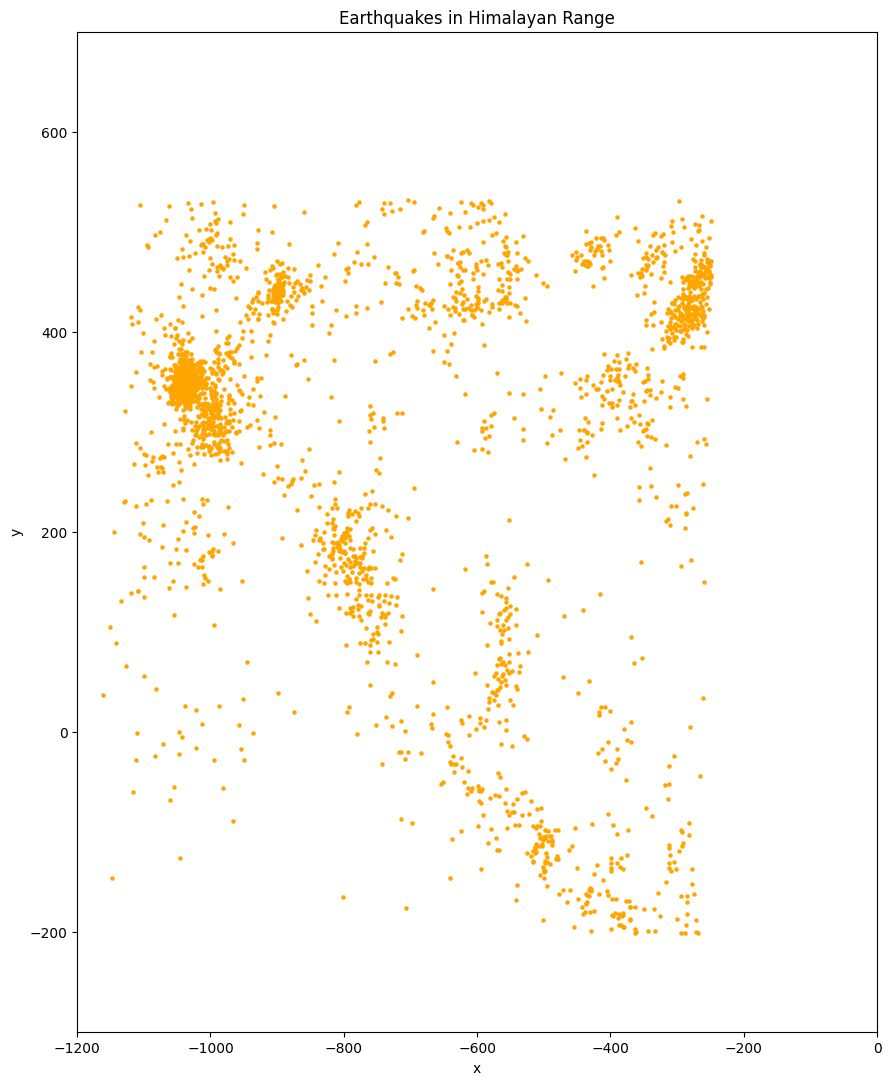

In [9]:
fig = plt.figure(figsize=(10, 12.5))

axes = fig.add_axes([0.1, 0.1, 0.8, 0.8])

axes.scatter(data['x'], data['y'], color='orange', marker='.', s=20)
plt.axis([-1200, 0, -300, 700])

axes.set_xlabel('x')
axes.set_ylabel('y')
axes.set_title('Earthquakes in Himalayan Range')

plt.show()

In [ ]:
data.to_csv('old.csv')

In [2]:
data = pd.read_csv('old.csv', sep=',')

In [3]:
LEFT_BORDER = -1200
RIGHT_BORDER = 0
DOWN_BORDER = -300
UP_BORDER = 700

N_CELLS_HOR = 200
N_CELLS_VER = 250

In [4]:
def create_celled_data(n_cells_hor, n_cells_ver, indicies):
    start_date  = int (data['time'][indicies[0]])
    finish_date = int (data['time'][indicies[-1]])
    celled_data = torch.zeros ([finish_date - start_date + 1, 1, n_cells_hor, n_cells_ver])

    cell_size_hor = (RIGHT_BORDER - LEFT_BORDER) / n_cells_hor
    cell_size_ver = (UP_BORDER    - DOWN_BORDER) / n_cells_ver

    for i in tqdm(indicies):
        if ((data['x'][i] > LEFT_BORDER)  and
            (data['x'][i] < RIGHT_BORDER) and
            (data['y'][i] > DOWN_BORDER)  and
            (data['y'][i] < UP_BORDER)):

            x = int (data['x'][i] / cell_size_hor)
            y = int (data['y'][i] / cell_size_ver)
            celled_data[int(data['time'][i]) - start_date, 0, x, y] = data['mag'][i]
    print (celled_data.shape)
    return celled_data

In [5]:
celled_data = create_celled_data(N_CELLS_HOR, N_CELLS_VER, range (data.shape[0]))


/tmp/ipykernel_11891/3614267874.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(indicies):


  0%|          | 0/2588 [00:00<?, ?it/s]

torch.Size([42223, 1, 200, 250])


In [ ]:
print(celled_data)

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0.

In [7]:
print(celled_data.shape)
print(celled_data.min())
print(celled_data.max())
print(torch.sum(celled_data != 0))

if torch.sum(celled_data != 0) == 0:
    print("No earthquakes were assigned to cells. Please check your data and grid setup.")


torch.Size([42223, 1, 200, 250])
tensor(0.)
tensor(7.9000)
tensor(2428)


In [8]:
freq_map = (celled_data>0).float().mean(dim=0)

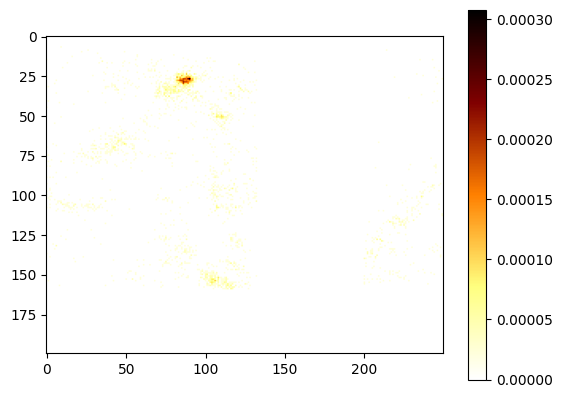

In [9]:
plt.imshow (freq_map.squeeze(0), cmap=plt.cm.afmhot_r)
plt.colorbar()

In [10]:
torch.save(celled_data,
           "celled_data_" +
           str(N_CELLS_HOR) +
           "x" +
           str(N_CELLS_VER))

torch.save(freq_map,
           "freq_map_" +
           str(N_CELLS_HOR) +
           "x" +
           str(N_CELLS_VER))


Training_loop


In [17]:
import os

import numpy as np

from tqdm import tqdm_notebook as tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve

import train
from model import *

%matplotlib inline

In [11]:
N_CELLS_HOR = 200
N_CELLS_VER = 250

In [12]:
celled_data = torch.load("celled_data_"
                         + str(N_CELLS_HOR)
                         + "x"
                         + str(N_CELLS_VER))
print (celled_data.shape)

torch.Size([42223, 1, 200, 250])


In [13]:
DEVICE_ID = 0
torch.cuda.set_device(DEVICE_ID)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print (DEVICE)

cuda


In [14]:
OBSERVED_DAYS = 30      
DAYS_TO_PREDICT_AFTER = 5
DAYS_TO_PREDICT_BEFORE = 20
TESTING_DAYS = 1000     

HEAVY_QUAKE_THRES = 3.5 


In [15]:
freq_map = (celled_data>HEAVY_QUAKE_THRES).float().mean(dim=0)


In [18]:
class Dataset_RNN_Train (Dataset):
    def __init__(self, celled_data):
        self.data = celled_data[0:
                                (celled_data.shape[0] -
                                 TESTING_DAYS)]
        self.size = (self.data.shape[0] -
                     DAYS_TO_PREDICT_BEFORE)

        print ('self.data :', self.data.shape)
        print ('size      :', self.size)

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        return (self.data[idx],
                torch.sum(self.data[(idx +
                                     DAYS_TO_PREDICT_AFTER):
                                    (idx +
                                     DAYS_TO_PREDICT_BEFORE)] > HEAVY_QUAKE_THRES,
                          dim=0,
                          keepdim=True).squeeze(0) > 0)


In [19]:
dataset_train = Dataset_RNN_Train (celled_data)

dataloader_train = DataLoader(dataset_train,
                              batch_size=1,
                              shuffle=False,
                              num_workers=1)

self.data : torch.Size([41223, 1, 200, 250])
size      : 41203


In [20]:
N_CYCLES = 5            
QUEUE_LENGHT = 20       
LEARNING_RATE = 0.001  
LR_DECAY = 5.0          
EARTHQUAKE_WEIGHT = 5000 


Done : 41200 / 41203


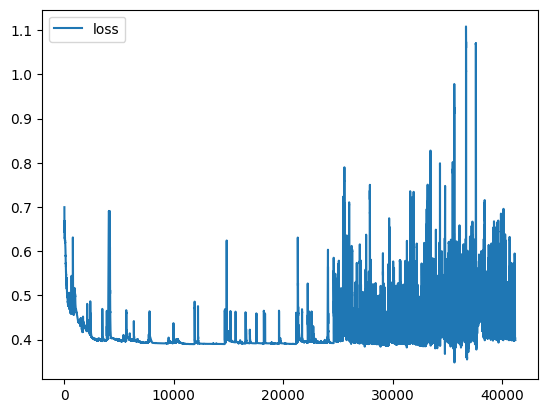

In [21]:
RNN_cell = LSTMCell(freq_map,
                    embedding_size    = EMB_SIZE,
                    hidden_state_size = HID_SIZE,
                    n_cells_hor       = N_CELLS_HOR,
                    n_cells_ver       = N_CELLS_VER,
                    device            = DEVICE)

train.train_RNN_full (RNN_cell,
                      DEVICE,
                      dataloader_train,
                      n_cycles=1,
                      learning_rate=LEARNING_RATE,
                      earthquake_weight=EARTHQUAKE_WEIGHT,
                      lr_decay=LR_DECAY)

In [22]:
if not os.path.exists("Model"):
    os.mkdir("Model")
torch.save(RNN_cell.state_dict(), "Model/state_dict")

Estimating_quality


In [23]:
import os

import numpy as np

from tqdm.notebook import tqdm  

import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import accuracy_score#
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve

%matplotlib inline

In [24]:
DEVICE_ID = 0
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(DEVICE_ID)
print (DEVICE)

cuda


In [25]:
N_CELLS_HOR = 200
N_CELLS_VER = 250

In [ ]:
celled_data = torch.load("celled_data_"
                         + str(N_CELLS_HOR)
                         + "x"
                         + str(N_CELLS_VER))
print (celled_data.shape)

In [35]:
OBSERVED_DAYS = 30      
DAYS_TO_PREDICT_AFTER = 5
DAYS_TO_PREDICT_BEFORE = 20
TESTING_DAYS = 1000     

HEAVY_QUAKE_THRES = 3.5 


In [36]:
freq_map = (celled_data>HEAVY_QUAKE_THRES).float().mean(dim=0)


In [37]:
class Dataset_RNN_Test (Dataset):
    def __init__(self, celled_data):
        self.data = celled_data[(celled_data.shape[0] -
                                 TESTING_DAYS):
                                (celled_data.shape[0])]
        self.size = (self.data.shape[0] -
                     DAYS_TO_PREDICT_BEFORE)

        print ('self.data :', self.data.shape)
        print ('size      :', self.size)

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        return (self.data[(idx)],
                torch.sum(self.data[(idx +
                                     DAYS_TO_PREDICT_AFTER):
                                    (idx +
                                     DAYS_TO_PREDICT_BEFORE)] > HEAVY_QUAKE_THRES,
                          dim=0,
                          keepdim=True).squeeze(0) > 0)

In [38]:
dataset_test  = Dataset_RNN_Test(celled_data)

dataloader_test  = DataLoader(dataset_test,
                              batch_size=1,
                              shuffle=False,
                              num_workers=1)

self.data : torch.Size([1000, 1, 200, 250])
size      : 980


In [39]:
from model import *

In [40]:
RNN_cell = LSTMCell(freq_map,
                    embedding_size    = EMB_SIZE,
                    hidden_state_size = HID_SIZE,
                    n_cells_hor       = N_CELLS_HOR,
                    n_cells_ver       = N_CELLS_VER,
                    device            = DEVICE)

RNN_cell.load_state_dict(torch.load("Model/state_dict"))
_ = RNN_cell.eval()

In [41]:
def my_precision_TPR_FPR (input, target, threshold):
    TP = torch.sum ((  (input>threshold) .float() * target      ).float())
    FP = torch.sum ((  (input>threshold) .float() * (1 - target)).float())
    FN = torch.sum (((~(input>threshold)).float() * target      ).float())
    TN = torch.sum (((~(input>threshold)).float() * (1 - target)).float())
    return TP / (TP + FP), TP / (TP + FN), FP / (FP + TN)

def check_quality (RNN_cell,
                   device,
                   dataloader_test,
                   n_dots=501,
                   info_file=None):

    prediction = torch.zeros(dataloader_test.__len__(),  N_CELLS_HOR, N_CELLS_VER,
                             device=device,
                             dtype=torch.float)
    prediction.detach_()
    target     = torch.zeros(dataloader_test.__len__(), N_CELLS_HOR, N_CELLS_VER,
                             device=device,
                             dtype=torch.float)
    target.detach_()

    RNN_cell.to(device)

    hid_state = RNN_cell.init_state(batch_size=1, device=device)
    if (type(hid_state) == tuple):
        for elem in hid_state:
            elem.detach_()
    else:
        hid_state.detach_()

    i = 0
    for data in tqdm(dataloader_test):

        inputs = data[0].to(device)
        labels = data[1].to(device).float()

        hid_state, outputs = RNN_cell.forward(inputs, hid_state)

        prediction[i] = outputs[:, 1, :, :]
        target    [i] = labels.squeeze(0)

        if (type(hid_state) == tuple):
            for elem in hid_state:
                elem.detach_()
        else:
            hid_state.detach_()
        prediction.detach_()
        target    .detach_()
        i += 1

    assert prediction.shape == target.shape
    prediction = prediction [10:prediction.shape[0]]  # cutting peace of data because
    target     = target     [10:target    .shape[0]]  # hidden state might be not good

    print ("ROC_AUC_score = ", end='')
    ROC_AUC_score = roc_auc_score(np.array(target    .view(-1).cpu()),
                                  np.array(prediction.view(-1).cpu()))
    print (ROC_AUC_score)

    print ("AVG_precision_score = ", end='')
    AVG_precision_score = average_precision_score(np.array(target    .view(-1).cpu()),
                                                  np.array(prediction.view(-1).cpu()))
    print (AVG_precision_score)

    threshold_massive = torch.linspace (0, 1, n_dots, dtype=torch.float, device=device)

    precision_massive = []
    recall_massive    = []
    FPR_massive       = []

    for threshold in tqdm(threshold_massive):
        precision, recall, FPR = my_precision_TPR_FPR(prediction, target, threshold)
        precision_massive.append(precision.item())
        recall_massive   .append(recall.item())
        FPR_massive      .append(FPR.item())

    # plot 1 precision
    fig = plt.figure(figsize=(10, 6))

    axes = fig.add_axes([0.1, 0.1, 0.8, 0.8])

    axes.plot(np.array(threshold_massive.cpu()), precision_massive, color='green', marker='.')

    axes.set_xlabel('threshold')
    axes.set_ylabel('precision')

    plt.show()

    # plot 2 recall
    fig = plt.figure(figsize=(10, 6))

    axes = fig.add_axes([0.1, 0.1, 0.8, 0.8])

    axes.plot(np.array(threshold_massive.cpu()), recall_massive, color='green', marker='.')

    axes.set_xlabel('threshold')
    axes.set_ylabel('recall')

    plt.show()

    # plot 3 ROC-curve
    fig = plt.figure(figsize=(8, 8))

    axes = fig.add_axes([0.1, 0.1, 0.8, 0.8])

    axes.plot(FPR_massive, recall_massive, 'orange', marker = '.')
    axes.plot (range(2), range(2), 'grey', ls='--')

    axes.set_xlabel('FPR')
    axes.set_ylabel('TPR (recall)')
    axes.set_title('ROC-curve')

    plt.show()

    # plot 4 precision-recall-curve
    fig = plt.figure(figsize=(8, 8))

    axes = fig.add_axes([0.1, 0.1, 0.8, 0.8])

    axes.plot(recall_massive, precision_massive, 'orange', marker = '.')

    axes.set_xlabel('Recall')
    axes.set_ylabel('Precision')
    axes.set_title('Precision_Recall_curve')

    plt.show()

    return ROC_AUC_score, AVG_precision_score


  0%|          | 0/980 [00:00<?, ?it/s]

ROC_AUC_score = 0.8497530132898123
AVG_precision_score = 0.0009594303013759072


  0%|          | 0/251 [00:00<?, ?it/s]

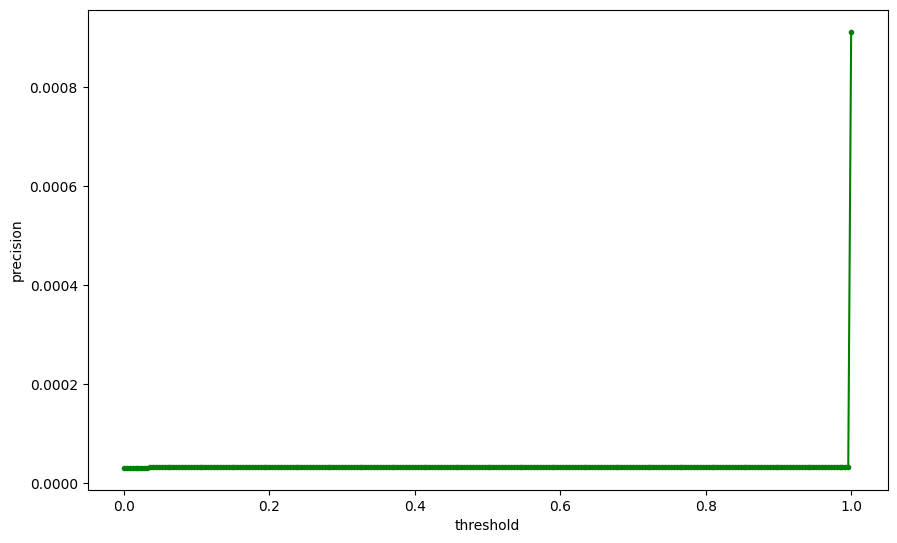

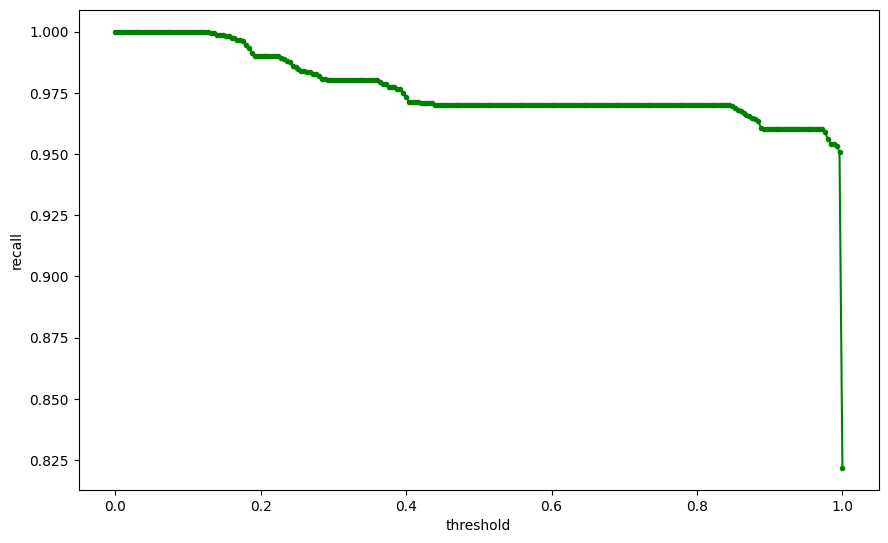

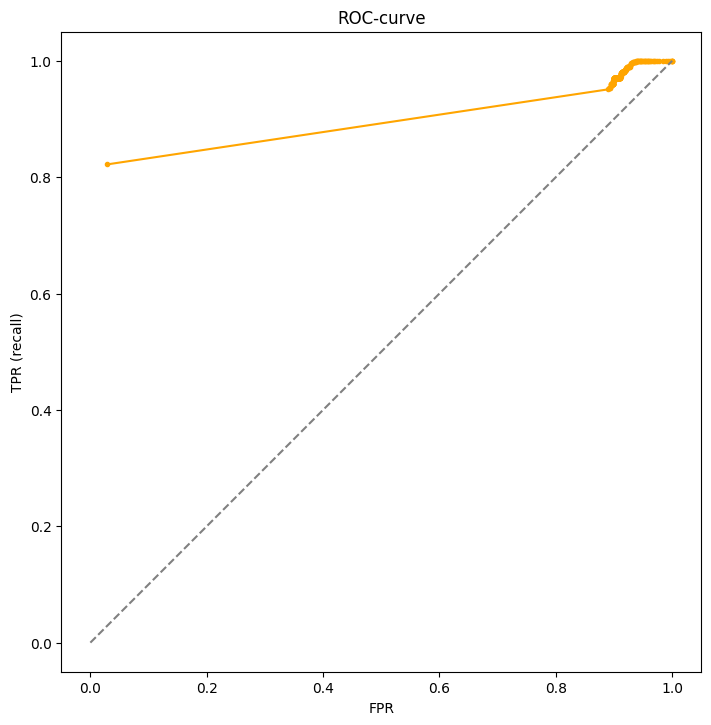

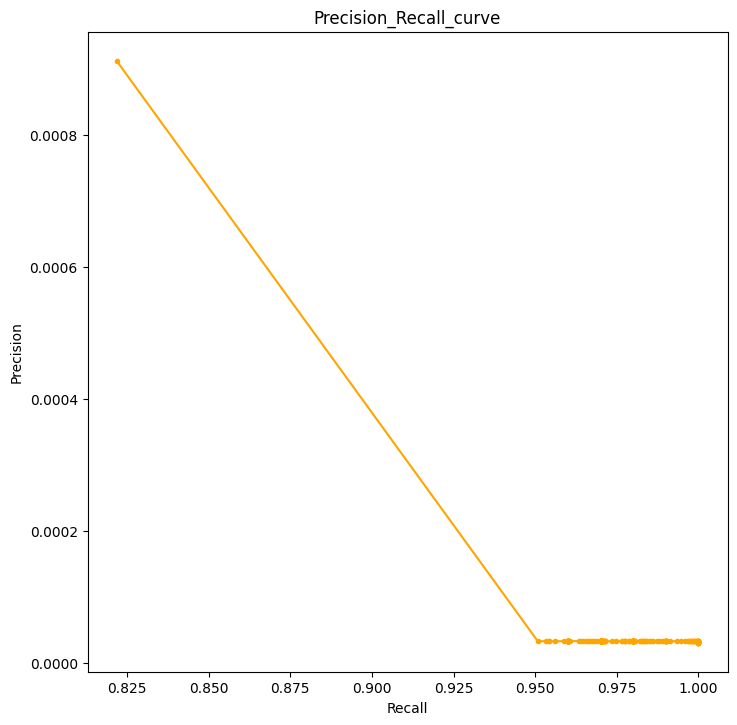

In [42]:
RNN_cell.eval()

ROC_AUC, AVG_prec = check_quality (RNN_cell,
                                   DEVICE,
                                   dataloader_test,
                                   n_dots=251)